In [1]:
import os
import seaborn as sns
import simplstyles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from voxelwise_tutorials.io import load_hdf5_array
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

from fmri.results import get_result_path

In [23]:
plt.style.use("nord-light-talk")

In [3]:
subject = 5
modality = "reading"
low_level_feature = "moten"

In [4]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
mapper = load_hdf5_array(mapper_path)
flatmap_mask = mapper['flatmap_mask']

In [5]:
semantic_path = os.path.join(get_result_path(modality, subject), "english1000_scores.csv")
vp_path = os.path.join(get_result_path(modality, subject), f"vp_english1000_{low_level_feature}_scores.csv")
rm_path = os.path.join(get_result_path(modality, subject), f"residual_{low_level_feature}_english1000_scores.csv")
rm_ridge_path = os.path.join(get_result_path(modality, subject), f"residual_ridge_{low_level_feature}_english1000_scores.csv")

In [6]:
semantic = pd.read_csv(semantic_path)
vp = pd.read_csv(vp_path)
rm = pd.read_csv(rm_path)
rm_ridge = pd.read_csv(rm_ridge_path)

semantic_correlation = np.array(semantic["correlation_score"])
vp_correlation = np.array(vp[f"semantic\\{low_level_feature}"])
rm_correlation = np.array(rm[f"correlation_score"])
rm_ridge_correlation = np.array(rm_ridge[f"correlation_score"])

# Scatterplot of visual cortex

In [7]:
v1_mask = mapper['roi_mask_V1']
v2_mask = mapper['roi_mask_V2']
v3_mask = mapper['roi_mask_V3']
all_masks = v1_mask + v2_mask + v3_mask
# set all values > 0 to 1
all_masks[all_masks > 0] = 1
all_masks = all_masks.astype(bool)

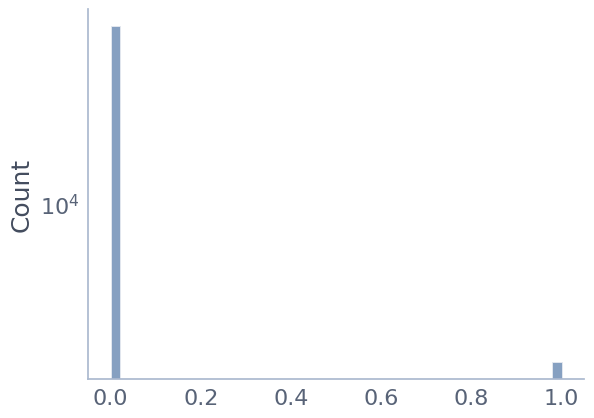

In [8]:
sns.histplot(all_masks, kde=False, bins=50)
plt.yscale('log')

<Axes: >

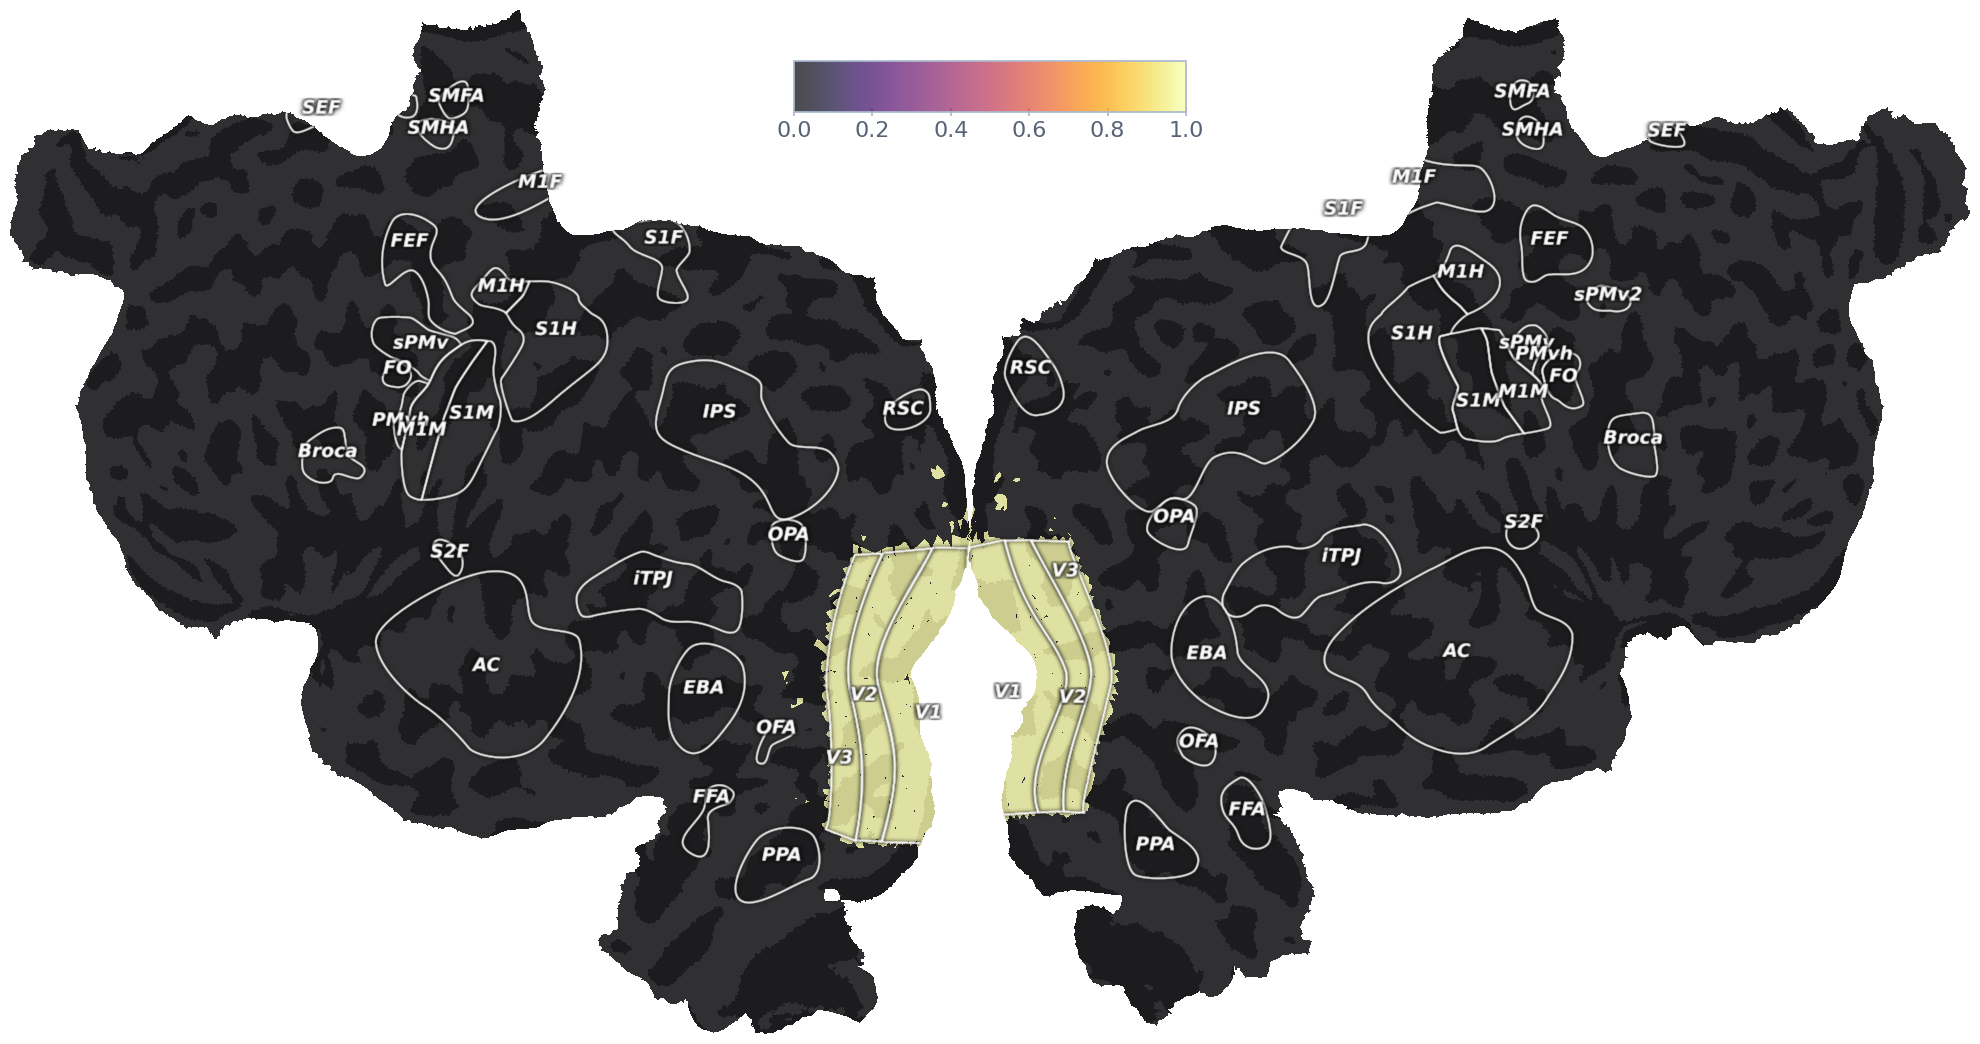

In [9]:
plot_flatmap_from_mapper(all_masks, mapper_path, vmin=0, vmax=all_masks.max())

# create all pairwise scatterplots in visualcorteces for semantic, variance partitioning, residual method ols and residual method ridge

In [10]:
data = pd.DataFrame()

visual_semantic = semantic_correlation[all_masks]
visual_rm = rm_correlation[all_masks]
visual_rm_ridge = rm_ridge_correlation[all_masks]
visual_vp = vp_correlation[all_masks]

data["Semantic"] = visual_semantic
data["Residual Method (Ridge)"] = visual_rm_ridge
data["Residual Method (OLS)"] = visual_rm
data["Variance Partitioning"] = visual_vp
vmax = data.max().max()
vmin = data.min().min()
print(vmin, vmax)

-0.3002694480166044 0.546333692437259


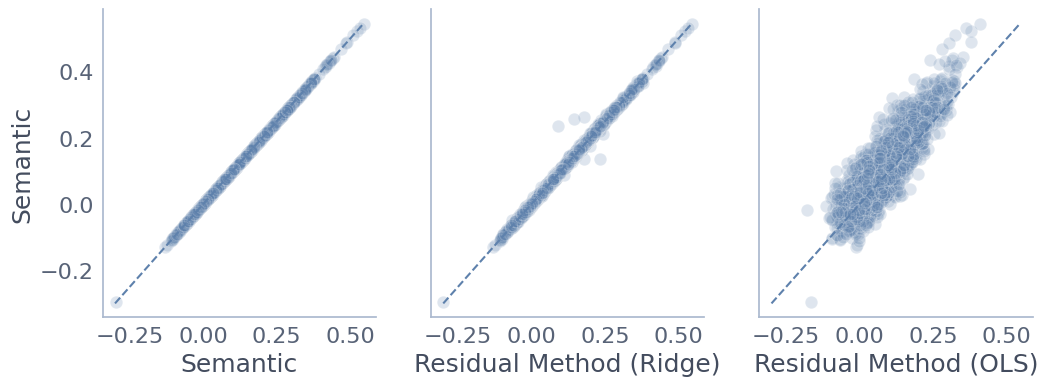

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, col in zip(axs, data.columns):
    sns.scatterplot(data, x=col, y="Semantic", ax=ax, alpha=0.2)
    sns.lineplot(x=[vmin, vmax], y=[vmin, vmax], linestyle='--', ax=ax)

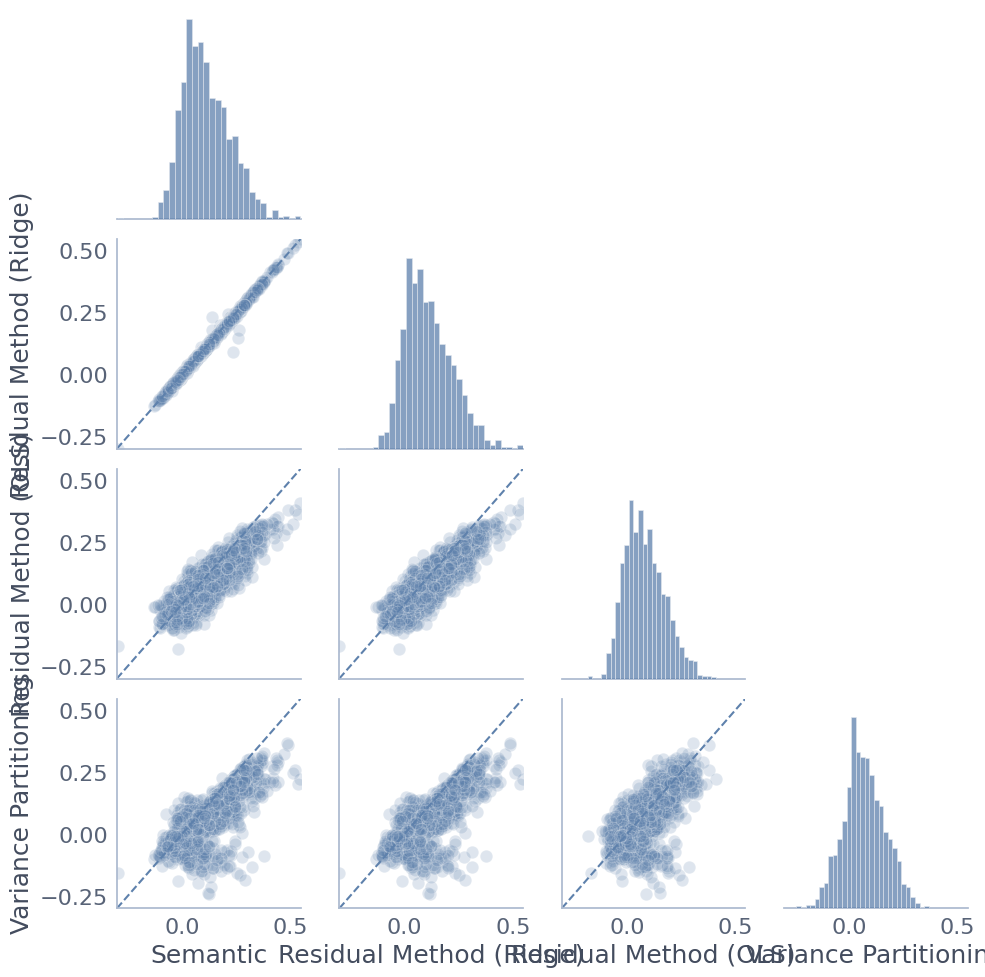

In [12]:
g = sns.pairplot(data, corner=True, plot_kws=dict(alpha=0.2))

# Loop through the axes
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        # Apply same x and y limits to all axes
        if ax is not None:
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)

            if i != j:  # Only modify non-diagonal plots
                sns.lineplot(
                    x=[vmin, vmax],
                    y=[vmin, vmax],
                    ax=ax,
                    # color="red",
                    linestyle="dashed"
                )

Text(0, 0.5, 'VC Prediction Accuracy')

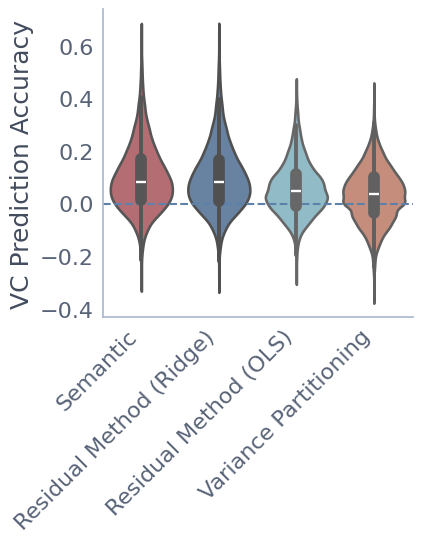

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

plt.axhline(0, linestyle='--')

for i, (column, color) in enumerate(zip(data.columns, ["C3", "C0", "C1", "C2"])):
    sns.violinplot(data, x=i, y=column, color=color)

plt.xticks(range(4), data.columns, rotation=45, ha="right")
plt.ylabel("VC Prediction Accuracy")

Compute amount removed compared to semantic

In [14]:
data_removed = data.iloc[:, 1:].apply(lambda x: data.iloc[:, 0] - x)

Text(0, 0.5, 'Semantic - Predicted')

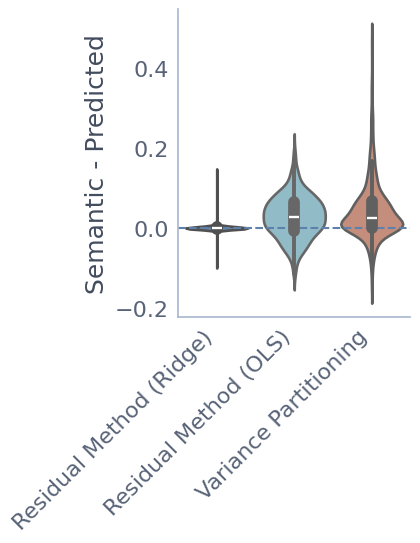

In [26]:
fig, ax = plt.subplots(figsize=(3, 4))

plt.axhline(0, linestyle='--')

for i, (column, color) in enumerate(zip(data_removed.columns, ["C0", "C1", "C2"])):
    sns.violinplot(data_removed, x=i, y=column, color=color)

plt.xticks(range(3), data_removed.columns, rotation=45, ha="right")
plt.ylabel("Semantic - Predicted")

# Plot VC results for all subjects

In [16]:
data = pd.DataFrame()

data["Semantic"] = []
data["Residual Method (Ridge)"] = []
data["Residual Method (OLS)"] = []
data["Variance Partitioning"] = []

In [17]:
for subject in range(1, 10):
    mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
    mapper = load_hdf5_array(mapper_path)
    if not mapper.keys().__contains__("roi_mask_V1"):
        print("skipping", subject)
        continue

    flatmap_mask = mapper['flatmap_mask']
    semantic_path = os.path.join(get_result_path(modality, subject), "english1000_scores.csv")
    vp_path = os.path.join(get_result_path(modality, subject), f"vp_english1000_{low_level_feature}_scores.csv")
    rm_path = os.path.join(get_result_path(modality, subject), f"residual_{low_level_feature}_english1000_scores.csv")
    rm_ridge_path = os.path.join(get_result_path(modality, subject),
                                 f"residual_ridge_{low_level_feature}_english1000_scores.csv")
    semantic = pd.read_csv(semantic_path)
    vp = pd.read_csv(vp_path)
    rm = pd.read_csv(rm_path)
    rm_ridge = pd.read_csv(rm_ridge_path)

    semantic_correlation = np.array(semantic["correlation_score"])
    vp_correlation = np.array(vp[f"semantic\\{low_level_feature}"])
    rm_correlation = np.array(rm[f"correlation_score"])
    rm_ridge_correlation = np.array(rm_ridge[f"correlation_score"])
    # Scatterplot of visual cortex
    v1_mask = mapper['roi_mask_V1']
    v2_mask = mapper['roi_mask_V2']
    v3_mask = mapper['roi_mask_V3']
    all_masks = v1_mask + v2_mask + v3_mask
    # set all values > 0 to 1
    all_masks[all_masks > 0] = 1
    all_masks = all_masks.astype(bool)

    visual_semantic = semantic_correlation[all_masks]
    visual_rm = rm_correlation[all_masks]
    visual_rm_ridge = rm_ridge_correlation[all_masks]
    visual_vp = vp_correlation[all_masks]

    _data = pd.DataFrame()
    _data["Semantic"] = visual_semantic
    _data["Residual Method (Ridge)"] = visual_rm_ridge
    _data["Residual Method (OLS)"] = visual_rm
    _data["Variance Partitioning"] = visual_vp

    data = pd.concat([data, _data])

skipping 4


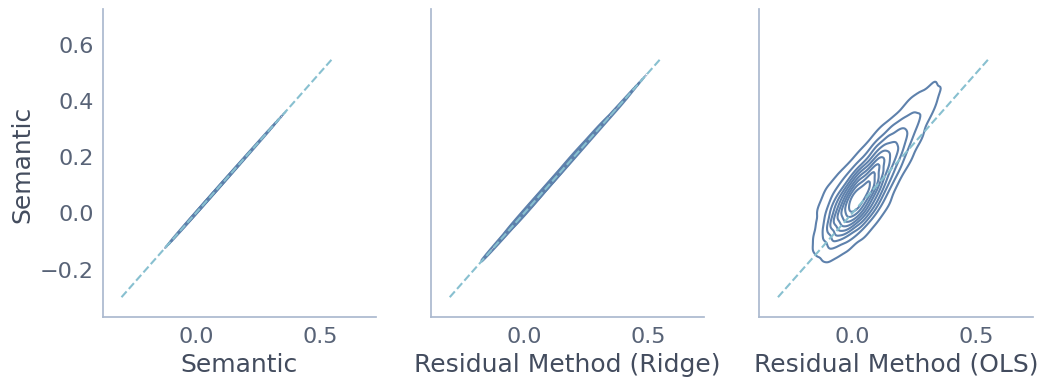

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, col in zip(axs, data.columns):
    sns.kdeplot(data, x=col, y="Semantic", ax=ax)
    # sns.scatterplot(data, x=col, y="Semantic", ax=ax, alpha=0.005)
    sns.lineplot(x=[vmin, vmax], y=[vmin, vmax], linestyle='--', ax=ax)